In [40]:
from camo_worms_utils import *

from itertools import product

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


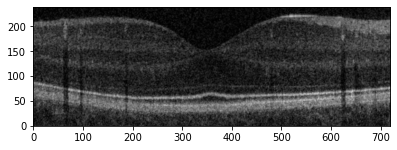

In [41]:
# Read, crop and display image and stats

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Initialise clew of 40 and draw

GENERATIONS = 15
POPULATION = 1000
PERCENT = 10

#clew = initialise_clew(40, image.shape, (40, 30, 1))
clew = initialise_clew(POPULATION, image.shape, (40, 30, 1))


#drawing = Drawing(image)
#drawing.add_worms(clew)
#drawing.show()

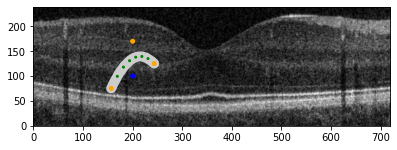

In [42]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')



drawing.show(save='bezier.png')

In [43]:
""" OLD METHOD
def average_distance(worm, clew):
    dists = []

    for i in range(len(clew)):
        # print("Distance: ({x1},{y1}) to ({x2},{y2})".format(x1=worm.x, y1=worm.y, x2=clew[i].x, y2=clew[i].y))
        euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
        # print(f"Worm centre ({worm.x}, {worm.y})")
        # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
        # print(f"Dist: {euclid_dist}")
        #print("euclid_dist:{}".format(euclid_dist))
        if(euclid_dist != 0):
            dists.append(euclid_dist)

        # don't bother checking if it's the same worm. It will just be a distance of 0.

    if(dists):  # not empty
        avg_dist = np.mean(dists)
    else:
        avg_dist = 0
        print("Nothing in list. Len={}".format(len(clew)))

    return avg_dist """


def count_overlaps(worm_idx, clew):

    # count-based - get proportion of other worms "touching" this worm
    # define "touching" as dist to other point is less than this.width+other.width
    count = 0
    for i in range(len(clew)):
        if i is not worm_idx:
            # base off of three intermediate points
            # i.e. add one to count if any points are too close
            points_worm = worm.intermediate_points()
            points_other = clew[i].intermediate_points()
            
            combos = list(product(points_worm, points_other))

            for point_worm, point_other in combos:
                euclid_dist = np.linalg.norm(
                    np.array(point_worm)-np.array(point_other)
                )
                # print(f"Points {point_worm}, {point_other}")
                # print(f"Widths {worm.width}, {clew[i].width}")
                # print(f"Dist {euclid_dist}\n")
                if euclid_dist < worm.width + clew[i].width:
                    # theyre touching
                    count += 1
                    break

    proportion = count/(len(clew)-1)
    # print(f"Count: {count}, Proportion: {proportion}")

    return proportion


""" OLD METHOD
def average_colour_diff(worm, image):

    # Range of 10 t values to gather points for
    t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9, 1.0]

    #print(t_range)

    total_colour_diff = 0
    count = 0

    for t in t_range:
        image_colour = worm.colour_at_t( t, image )
        if(image_colour > -1): # If it returns -1, it means the point is outside the image
            count = count + 1
            total_colour_diff = total_colour_diff + abs(worm.colour - image_colour)
        else:
            # assume maximum difference as penalty
            count = count + 1
            total_colour_diff = total_colour_diff + 255

    #print(total_colour_diff)
    if(count > 0):
          colour_diff_ave = total_colour_diff/count # To get average, divide by 10 samples
    else: colour_diff_ave=0
    return colour_diff_ave """

""" def average_contrast(worm, image):
    # Gather points at boundary of worm to test
    total_contrast = 0
    count = 0

    for edge_point in worm.edge_points(5):
        # Get image colour at boundary
        x = round(edge_point[0])    # Only whole indexes are allowed
        y = round(edge_point[1])    # The maths that finds edge points can get decimals
        image_colour = worm.colour_at_xy( x, y, image)
        #print("Colour difference at (x,y)=({},{})\nWorm Colour = {}\nImage Colour ={}".format(x,y, worm.colour, image_colour))
        # Calculate contrast by comparing worm body colour with edge colour
        # Assume worm is similar colour to background because of score function
        total_contrast = total_contrast + abs(image_colour - worm.colour)
        count = count + 1

    if(count > 0):
          contrast_ave = total_contrast/count # To get average, divide by 10 samples
    else: contrast_ave=0
    return contrast_ave """



' def average_contrast(worm, image):\n    # Gather points at boundary of worm to test\n    total_contrast = 0\n    count = 0\n\n    for edge_point in worm.edge_points(5):\n        # Get image colour at boundary\n        x = round(edge_point[0])    # Only whole indexes are allowed\n        y = round(edge_point[1])    # The maths that finds edge points can get decimals\n        image_colour = worm.colour_at_xy( x, y, image)\n        #print("Colour difference at (x,y)=({},{})\nWorm Colour = {}\nImage Colour ={}".format(x,y, worm.colour, image_colour))\n        # Calculate contrast by comparing worm body colour with edge colour\n        # Assume worm is similar colour to background because of score function\n        total_contrast = total_contrast + abs(image_colour - worm.colour)\n        count = count + 1\n\n    if(count > 0):\n          contrast_ave = total_contrast/count # To get average, divide by 10 samples\n    else: contrast_ave=0\n    return contrast_ave '

The Sorting function

In [44]:
# a sorting function
def eval_worm(worm_idx, clew_var=clew, image_var=image, size_weight=100, overlap_weight=1300, colour_weight=1500, contrast_weight=150, print_results=False):
    # NOTE: image and clew is hardcoded, as variables can't be passed through sort(key=...)

    score = 0

    worm = clew_var[worm_idx]

    #contrast_weight=80
    
    # ------------ Internal Knowledge ------------
    
    # --- Size ---
    # Big Worms to counteract 1 pixel worms being highest score
    size = worm.approx_length() / image_var.shape[1] # size as a percentage of image width
    size_comp = size_weight*size
    
    
    # ------------ Group Knowledge ------------
    
    # --- Average Distance ---
    """old method
    #dist_weight=0.2
    #average_dist = average_distance(worm, clew_var)
    #dist_comp = dist_weight * average_dist 
    
    average_dist = average_distance(worm, clew_var)
    # option1
    # want worms spread out (add small constant to prevent divide by 0)
    # take min with 1 to keep on scale 0 to 1
    inversed = min(1/(average_dist+0.00001), 1)
    # define as 0 for some ideal distance apart (should define it better than max(image.shape))
    #if average_dist > max(image.shape):
    #    inversed = 0
    ## define as 1 for too far apart
    #if average_dist > max(image.shape)*1.05:
    ##    inversed = 1
    dist_comp = dist_weight * inversed
    """

    #dist_comp = 0
    
    proportion = count_overlaps(worm_idx, clew)
    overlap_comp = overlap_weight * proportion


    
    # ------------ Environmental Knowledge ------------

    # --- Colour Difference ---
    # Compare to colour (inverse)
    #colour_diff = average_colour_diff(worm, image_var)

    colour_score = np.abs(worm.get_mean_colour_under(image) - worm.colour)
    colour_comp = colour_weight* -colour_score


    # --- Contrast ---
    # Find hard edges around worm
    #contrast = average_contrast(worm, image)
    contrast = 0
    contrast_comp = contrast_weight*contrast


    # ------------ Final Calibration ------------

    # Sort doesn't work with decimals
    score = round( (size_comp + overlap_comp + colour_comp + contrast_comp)*1000 )

    if(score < 0):
        score = 0 # No negatives allowed for sorting. Assume anything with a score of 0 will get discarded.

    if(print_results):
        print( "    Score: (sz={print_size}) + (dist={print_dist}) + (col={print_colour}) + (con={print_contrast}) = {print_score}".format(
            print_size=size_comp,
            print_dist = overlap_comp,
            print_colour=colour_comp,
            print_contrast = contrast_comp,
            print_score = score) )
    
    return score

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


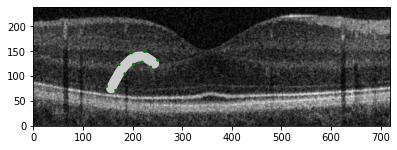

(240, 720)


In [45]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)

t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9]
print(t_range)

# coords = []
# for t in t_range:
#     print(worm.coords_at_t(t))
#     coords.append(  worm.coords_at_t(t) )

#print(coords)

drawing = Drawing(image)
drawing.add_worms(worm)
#drawing.add_dots(coords, radius=2, color='green')
drawing.add_dots(worm.edge_points(5), radius=2, color='green')

drawing.show(save='bezier.png')


print(image.shape)
# reversed as [y, x]

In [46]:
def get_fittest(image, clew: list[Camo_Worm], w_internal: float=1.0, w_group: float=1.0, w_environment: float=1.0):
    #scores = [get_cost(image, i, clew, w_internal, w_group, w_environment) for i, worm in enumerate(clew)]
    scores = [eval_worm(i) for i, worm in enumerate(clew)]
    #print(scores)
    #costs = [score[0] for score in scores]
    #internal_scores = [score[1] for score in scores]
    #group_scores = [score[2] for score in scores]
    #enviro_scores = [score[3] for score in scores]
    #sorted_clew = sorted(zip(clew, costs), key=lambda x: x[1])
    sorted_clew = sorted(zip(clew, scores), key=lambda x: x[1])
    """return (
        [worm for worm,cost in sorted_clew[:top_n]],
        np.mean(costs),
        np.mean(internal_scores),
        np.mean(group_scores),
        np.mean(enviro_scores)
    )"""
    return (
        [worm for worm,cost in sorted_clew]
    )

In [47]:



# hardcode 10 generations
for gen in range(GENERATIONS):

    print("--------Generation {}------------".format(gen))
    
    # sort in order with a scoring function

    
    #clew = sorted(clew, key=eval_worm, reverse=True) # this will only work because eval_worm has one argument
    clew = get_fittest(image, clew)

    # clew.sort(key= eval_worm) # this will only work because eval_worm has one argument
    # clew.reverse() # need to reverse because higher numbers get put at bottom

    # Test of first 5 values
    print("Test first 5 vals")
    for i in range(5):
        #current_worm = clew[i]
        current_worm_idx = i
        score = eval_worm(current_worm_idx, print_results=True)

    drawing = Drawing(image)
    drawing.add_worms(clew)

    best_worm = clew[0]
    print("Best Worm:")
    eval_worm(best_worm, print_results=True)
    #print("    Best environment worm point: x %2d, y %2d" %(best_worm.x, best_worm.y))
    #print("    Length: %.2f, width %.2f and colour: %.2f" % (best_worm.approx_length(), best_worm.width, best_worm.colour* 255 ))
    drawing.add_worms(best_worm) # put it on top
    #drawing.add_dots(best_worm.intermediate_points(5), 2, color="orange")
    drawing.add_dots(best_worm.edge_points(5), 2, color="green")

    drawing.show()
    
    n = 0
    total = 0
    #for worm in clew:
    for worm_idx, worm in enumerate(clew):
        #score = eval_worm(worm, print_results=True)
        score = eval_worm(worm_idx)
        #print(score)
        n += 1
        total += score
    ave=total/n
    print("Average Score: {}".format(ave))
    
    
    # get top 10% to start next generation
    ten_perc = round( (PERCENT/100) * POPULATION )

    new_clew = []
    for i in range(ten_perc):
        new_clew.append( clew[i] )
    
    # use top 10% to generate the rest of the population
    # ------------- TO FIX: CURRENTLY BOTH PARENTS CAN BE SAME ------------------
    
    for i in range( POPULATION - ten_perc ): # get remaining 90% of pop
    
        rand1 = rng.integers(0, ten_perc) # pick one of the top 10%
        parent1 = clew[rand1]

        rand2 = rng.integers(0, ten_perc)
        parent2 = clew[rand2]

        child = parent1.mate(parent2, image)
        new_clew.append(child)
    
    # replace the previous generation
    clew = new_clew
    
    #print(len(clew))
    
    

--------Generation 0------------


KeyboardInterrupt: 

&copy; Cara MacNish, UWA, 2024